# Neural Style Transfer

### Important Libraries Used
 - Tensorflow (2.0 alpha)
 - Keras
 - Matplotlib
 - Pandas
 - Numpy
 - Pillow
 - Scikit-learn
 - Function tools

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from PIL import Image
import time
import functools
import IPython.display


In [2]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

#### Check for eager execution

In [3]:
tf.executing_eagerly()

True

#### Setting path for Style image and Content image

In [4]:
style_path='picasso_selfportrait.jpg'

In [5]:
content_path='japanese_garden.jpg'

Loading image and setting dimension

In [6]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
    img = kp_image.img_to_array(img)
  
     # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

### Visualising input image using pyplot

In [7]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display `
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

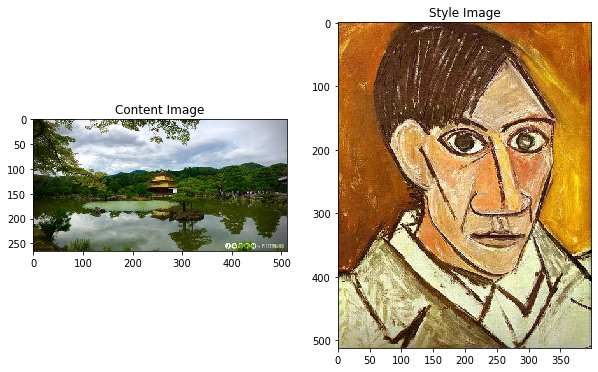

In [8]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

### Preprocessing the Data
We are using VGG19 network architecture, a pretrained image classification network, as suggested in __[Leon A. Gatys’ paper, A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)__ .

Preprocessing is done with the help of the tf.keras module:

img =tf.keras.applications.vgg19.preprocess_input(img)

In [9]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Visualising

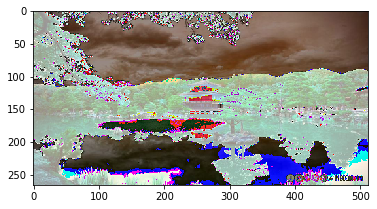

In [10]:
img= load_and_process_img(content_path)
imshow(img)

### Deprocessing the output
As our optimised image can take any value between  $- \infty$ and $\infty$, we have to clip the values to maintain it within the range of 0-255

In [11]:

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Generating the Model
We use the intermediate layers in our model to define the representation of content and style from our images. We use this to map out content and style features into the pre-trained VGG19 model.

1. **Content Layer** : Deeper layers must be used to capture higher feautures of the content image. Layers used:
    - block5_conv2
    - block4_conv2
    - block4_conv4


2. **Style Layer** : Earlier(shallower) layers must be used to capture low level features of the style image. Layers used:
    - block1_conv1
    - block2_conv1
    - block3_conv1
    - block4_conv1
    - block5_conv1

In [12]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2','block4_conv2','block4_conv4'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
print("num_content_layers:",num_content_layers,"\nnum_style_layers:",num_style_layers)

num_content_layers: 3 
num_style_layers: 5


We load the VGG19 Model and access the intermediate layers, and build our model.

In [14]:
def get_model():

  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [15]:
model=get_model()

Visualising model summary

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Content Loss
Let $C_{nn}$ be a pre-trained deep convolutional neural network. Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as:

$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

In [17]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

### Style Loss
For the style loss we compare the Gram matrices of the two outputs. The contribution of each layer to the total style loss is described by:

$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$
where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$

In [18]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

### Applying Style Transfer
We first load and preprocess both the content and style images from their path. Then it will feed them through the network to obtain the outputs of the intermediate layers. 

In [19]:
def get_feature_representations(model, content_path, style_path):
    
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

### Compute Total Loss

In [20]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
 
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

### Computing Gradient
We use **tf.GradientTape** to compute the gradient.
We take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

We use the Adam optimizer in order to minimize our loss.

In [21]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Performing Style Transfer

In [22]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't want to train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  
  display_interval = 10
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    print("=",end=" ")
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      #IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('\nIteration: {}'.format(i))        
      print('Total loss: {:.4f}, ' 
            'style loss: {:.4f}, '
            'content loss: {:.4f}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
 
  return best_img, best_loss

= 

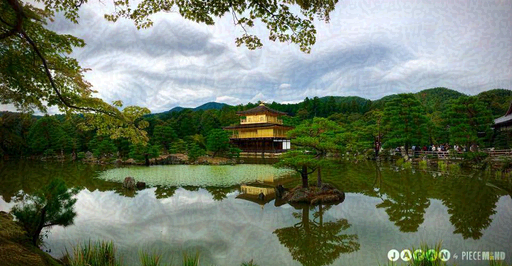


Iteration: 0
Total loss: 297977120.0000, style loss: 297977120.0000, content loss: 0.0000, time: 0.0409s
= = = = = = = = = = 

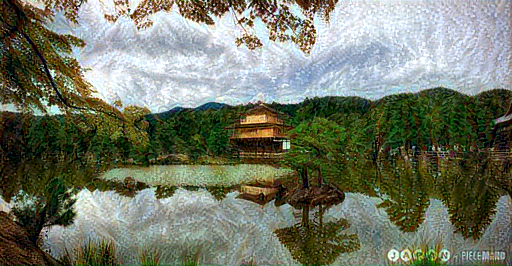


Iteration: 10
Total loss: 131256496.0000, style loss: 46930604.0000, content loss: 84325888.0000, time: 0.0309s
= = = = = = = = = = 

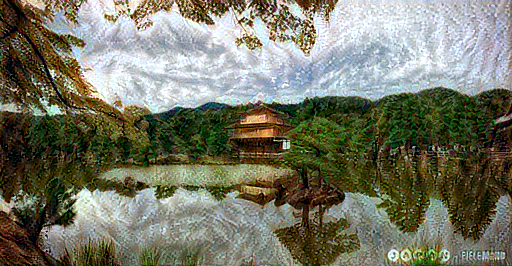


Iteration: 20
Total loss: 115395656.0000, style loss: 36013072.0000, content loss: 79382584.0000, time: 0.0309s
= = = = = = = = = = 

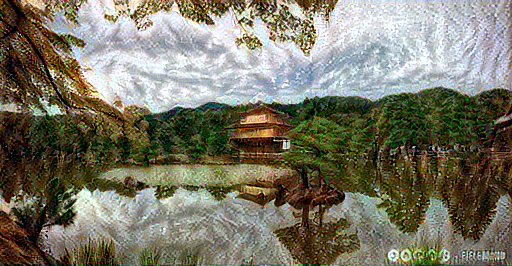


Iteration: 30
Total loss: 107115136.0000, style loss: 31407884.0000, content loss: 75707248.0000, time: 0.0299s
= = = = = = = = = = 

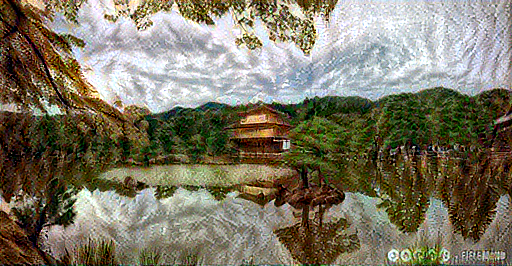


Iteration: 40
Total loss: 101861248.0000, style loss: 29075560.0000, content loss: 72785688.0000, time: 0.0310s
= = = = = = = = = = 

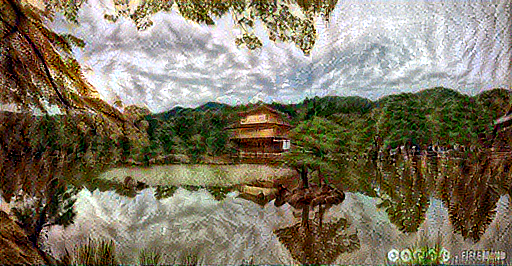


Iteration: 50
Total loss: 97837088.0000, style loss: 27587806.0000, content loss: 70249280.0000, time: 0.0368s
= = = = = = = = = = 

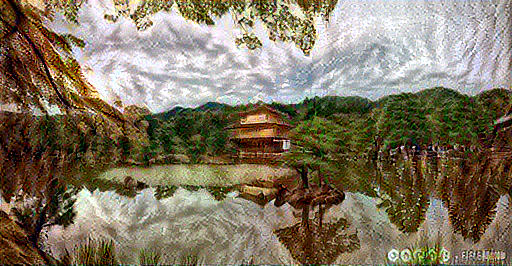


Iteration: 60
Total loss: 94616648.0000, style loss: 26308946.0000, content loss: 68307704.0000, time: 0.0299s
= = = = = = = = = = 

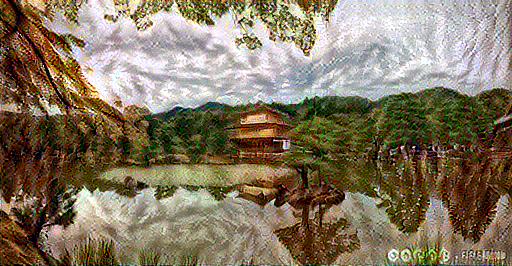


Iteration: 70
Total loss: 92172544.0000, style loss: 25488666.0000, content loss: 66683876.0000, time: 0.0309s
= = = = = = = = = = 

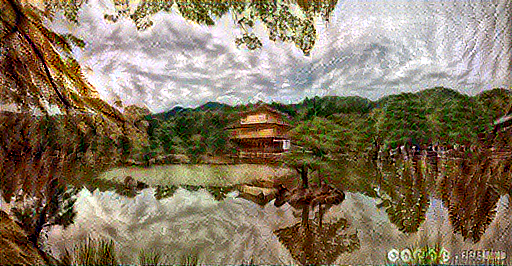


Iteration: 80
Total loss: 90138384.0000, style loss: 24995706.0000, content loss: 65142676.0000, time: 0.0299s
= = = = = = = = = = 

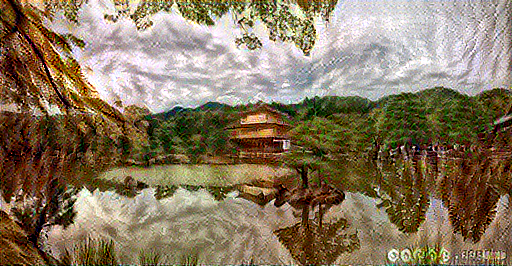


Iteration: 90
Total loss: 88423288.0000, style loss: 24281010.0000, content loss: 64142280.0000, time: 0.0309s
= = = = = = = = = = 

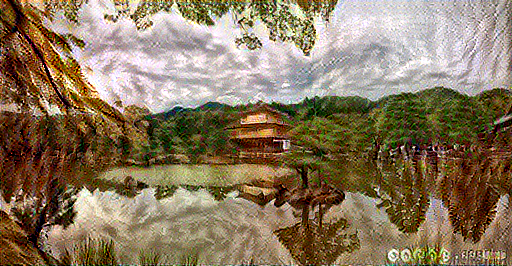


Iteration: 100
Total loss: 86896240.0000, style loss: 23819266.0000, content loss: 63076976.0000, time: 0.0299s
= = = = = = = = = = 

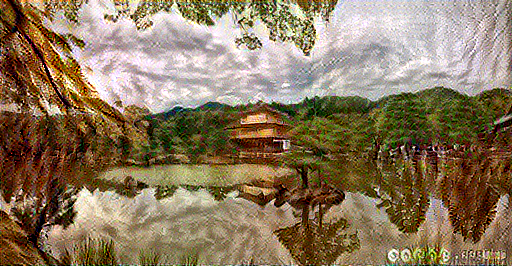


Iteration: 110
Total loss: 85622808.0000, style loss: 23536572.0000, content loss: 62086236.0000, time: 0.0319s
= = = = = = = = = = 

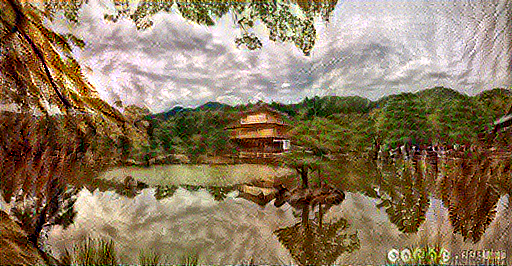


Iteration: 120
Total loss: 84502896.0000, style loss: 23320874.0000, content loss: 61182024.0000, time: 0.0299s
= = = = = = = = = = 

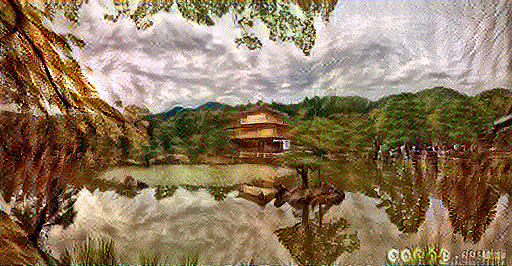


Iteration: 130
Total loss: 83499256.0000, style loss: 22965194.0000, content loss: 60534060.0000, time: 0.0299s
= = = = = = = = = = 

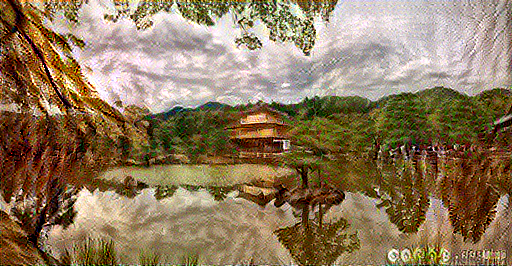


Iteration: 140
Total loss: 82583440.0000, style loss: 22650222.0000, content loss: 59933220.0000, time: 0.0301s
= = = = = = = = = 

In [23]:

best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=150)

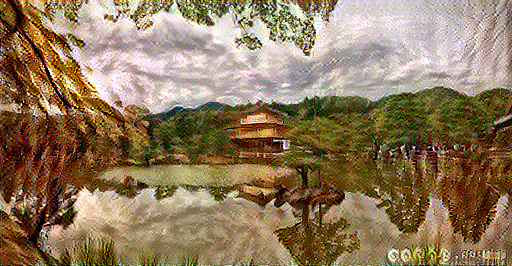

In [24]:
Image.fromarray(best)

In [25]:

def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

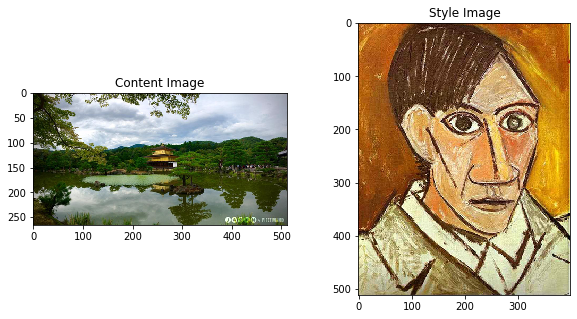

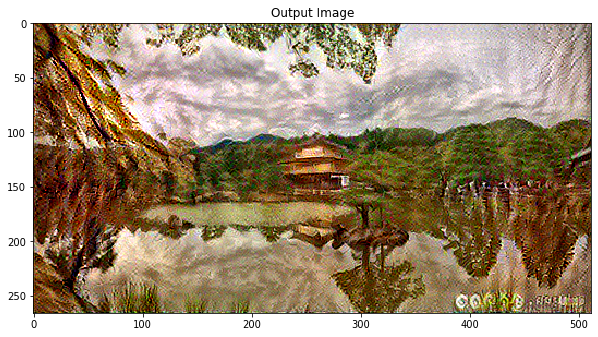

In [26]:
show_results(best, content_path, style_path)


In [27]:
result = Image.fromarray(best)
size = Image.open(content_path).size
result.thumbnail(size, Image.ANTIALIAS)
result.save('out.jpeg',"JPEG")